<a href="https://colab.research.google.com/github/shaileyj/CS175_project/blob/main/StockTrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/CS175

/content/drive/MyDrive/CS175


https://gymnasium.farama.org/introduction/create_custom_env/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import warnings
from datetime import datetime
warnings.filterwarnings("ignore", category=DeprecationWarning)

List of things I am not certain about
*   Do episodes end? If not, we don't need to write reset. If yes, what should happen when we reset?
     * My initial idea was that we have 3 training periods, so I guess each training period can be an episode?
     * Actually, I think we should randomly sample episodes (like 2 weeks long?) from the training data, so that we have a lot of episodes
*   Good value of starting funds
     * I think $13000 ($1k for each stock) is good, and then give each cluster money equal to (# stocks in cluster) * 1000
*   how to render/visualize an episode (Professor Xie said he wants to see this during presentations yesterday)
     * Line graph of overall portfolio value (maybe line for each cluster too?)
*   Penalty for an illegal move (should money it made from other parts of the action still be factored in? Should the entire action be denied and just give it a flat penalty of like -1000 or whatever?)
     * I think illegal moves should be entirely denied, but not entirely sure
          * The thing I'm worried about is that because of the clustering, one action is actually several actions. If one of these is illegal, and we treat the whole action as illegal, it might be hard for it to figure out what makes a move illegal since there are too many possible ways for it to happen. Let's try flat penalty for now though, because it's easier to implement.
*   Size of action space- currently range is essentially -infinity to infinity, but you can't exactly buy infinite shares of a stock. It's kind of hard to say exactly how much of a stock you can buy though because apparently nintendo has like a billion shares according to some reddit user? We could cap it at whatever seems reasonable for it to grow to based on the starting budget and the values of stocks. In any case, I think we need to constrain it.
     * What if we view each action as buying a certain amount of money of a stock, rather than buying a certain number of shares?
        * I think it might be hard to learn how much you can sell legally if stocks are represented in money because the correlation between money spent and how much the stock is worth now is harder to figure out for a human, and probably the same for a neural network
     * This way, the action space for each cluster is a vector of size equal to the # of stocks in that cluster. Each element of that vector is in range (-x, b), where x = dollars invested in stock and b = remaining budget for that cluster
     * If concerned about overfitting or too many dimensions in this approach ^^, maybe we can just have one value for each cluster that determines how much money to invest in each cluster. Within that cluster, the money will be equally allocated among all stocks in that cluster. Stocks within same cluster should have similar performance anyways
*   It might be better to store current budget in a separate variable to avoid confusion




In [ ]:
file_start = "sentiment_stock_data/"
file_end = "_sentiment.csv"

In [ ]:
from datetime import datetime
def time_binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    x = datetime.fromisoformat(x)
    while low <= high:
        mid = low + (high - low) // 2
        date = datetime.fromisoformat(arr[mid])
        if date == x:
            return mid
        elif date < x:
            low = mid + 1
        else:
            high = mid - 1
    return -1

In [ ]:
class StockEnv(gym.Env):
  def __init__(self, stocks, mode, funds_per_stock=1000, episode_length=80):
    """
    stocks is the list of stocks that this cluster will act on.
    mode is either train, validation, or test, and indicates if the model will act on the training, validation, or testing data.
    funds_per_stock is the per-stock starting budget.
    episode_length is the length of each training episode.
    """
    self.stocks = [pd.read_csv(file_start + stock + file_end) for stock in stocks]
    self.risk_free_rates = pd.read_csv('risk_free_rates.csv')
    self.mode = mode
    self.start_funds = funds_per_stock * len(stocks)
    self.episode_length = episode_length
    self.episode_num = 0
    self.train_profits = [] # one entry per episode, representing episode's profits
    self.train_market_roi = [] # one entry per episode, representing episode's ROI
    self.val_net_worth = [] # one entry for model's budget + one entry per stock per timestep, representing model's money in a stock
    self.val_roi = [] # one entry per stock per timestep, representing total value of stocks
    self.test_net_worth = [] # one entry for model's budget + one entry per stock per timestep, representing model's money in a stock
    self.test_roi = [] # one entry per stock per timestep, representing total value of a stock
    self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(len(stocks),), dtype=np.float32)
    self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape = (5 * 6 * len(stocks) + len(stocks) + 1,), dtype=np.float32) #5 previous states with 6 datapoints each, self.funds
    self.reset()

  def _get_obs(self):
    columns_to_keep = ["open", "high", "low", "close", "volume", "sentiment"]
    obs = []
    for j in range(0, -5, -1):
      for stock_df in self.stocks:
        obs.extend(stock_df[columns_to_keep].iloc[self.stocks_i+j].to_list())
    obs.extend(list(self.funds))
    obs.append(self.budget)
    return np.array(obs, dtype=np.float32)

  def _get_info(self):
    return {"Net worth": self.net_worth,
            "Funds": self.funds,
            "Remaining budget": self.budget}

  def _set_risk_i(self):
    target_date = datetime.strptime(self.stocks[0]["datetime"].iloc[self.stocks_i], "%Y-%m-%d %H:%M:%S")
    curr_date = datetime.strptime(self.risk_free_rates["observation_date"][self.risk_i], "%Y-%m-%d")
    while curr_date < target_date and self.risk_i < len(self.risk_free_rates) - 1:
      self.risk_i += 1
      curr_date = datetime.strptime(self.risk_free_rates["observation_date"][self.risk_i], "%Y-%m-%d")

  def reset(self, seed=None):
    self.episode_num += 1
    self.funds = np.zeros(len(self.stocks), dtype=np.float32)
    self.budget = self.start_funds
    self.net_worth = self.budget
    self.steps = 0
    if self.mode == "train":
      self.stocks_i = np.random.randint(4, int(0.8 * len(self.stocks[0])) - self.episode_length)
    elif self.mode == "validation":
      self.stocks_i = int(0.8 * len(self.stocks[0])) + 5
    else:
      self.stocks_i = int(0.9 * len(self.stocks[0])) + 5
    self.risk_i = 0
    self._set_risk_i()
    self.returns = []
    observation = self._get_obs()
    info = self._get_info()
    return (observation, info)

  def step(self, action):
    # Action is fraction of shares to sell or fraction of budget to use on buying shares
    action = np.clip(action, -1, 1)
    prices = np.array([df.iloc[self.stocks_i]["close"] for df in self.stocks])

    # Process sells
    shares_delta = np.clip(action, -1, 0) * self.funds
    self.budget -= np.sum(shares_delta * prices)
    self.funds += shares_delta

    # Process buys
    buy_actions = np.clip(action, 0, 1)
    total_buys = np.sum(buy_actions)
    if (total_buys > 1):
      buy_actions = buy_actions / total_buys
    budget_deltas = buy_actions * self.budget
    self.budget -= np.sum(budget_deltas)
    self.funds += budget_deltas / prices

    self.stocks_i += 1
    self.steps += 1
    new_net_worth = np.sum(self.funds * prices) + self.budget
    reward = (new_net_worth - self.net_worth) / self.net_worth
    self.returns.append(reward)
    self.net_worth = new_net_worth
    # if (self.steps % 10 == 0):
    #   self._set_risk_i()
    #   risk_free_rate_annual = self.risk_free_rates["DTB3"][self.risk_i]
    #   risk_free_rate_hourly = (1 + risk_free_rate_annual) ** (1 / (252 * 8)) - 1
    #   reward = (np.mean(self.returns) - risk_free_rate_hourly) / (np.std(self.returns) + 1e-8)
    #   self.returns = []
    # else:
    #   reward = 0

    if self.mode == "train":
      done = self.steps >= self.episode_length
      if done:
        self._set_risk_i()
        risk_free_rate_annual = self.risk_free_rates["DTB3"][self.risk_i]
        risk_free_rate_hourly = (1 + risk_free_rate_annual) ** (1 / (252 * 8)) - 1
        sharpe = (np.mean(self.returns) - risk_free_rate_hourly) / (np.std(self.returns) + 1e-8)
        alpha_sharpe = (np.mean(np.abs(self.returns)) + 1e-8) / (np.abs(sharpe) + 1e-8) # scale Sharpe bonus to match reward's scale
        reward += alpha_sharpe * sharpe
        self.train_profits.append(self.net_worth - self.start_funds)
        prices = np.array([df.iloc[self.stocks_i]["close"] for df in self.stocks])
        start_prices = np.array([df.iloc[self.stocks_i - self.steps]["close"] for df in self.stocks])
        start_shares = (self.start_funds / len(self.stocks)) / start_prices
        end_prices = prices * start_shares
        self.train_market_roi.append(np.sum(end_prices) - self.start_funds)
    elif self.mode == "validation":
      done = self.stocks_i >= int(0.9 * len(self.stocks[0]))
      entry = np.concatenate((np.array([self.budget]), self.funds * prices))
      self.val_net_worth.append(entry)
      i = int(0.8 * len(self.stocks[0])) + 5
      prices = np.array([df.iloc[self.stocks_i]["close"] for df in self.stocks])
      start_prices = np.array([df.iloc[i]["close"] for df in self.stocks])
      start_shares = (self.start_funds / len(self.stocks)) / start_prices
      end_prices = prices * start_shares
      self.val_roi.append(end_prices)
    else:
      done = self.stocks_i >= min([len(stock) for stock in self.stocks])
      if done:
        self.stocks_i -= 1
        return self._get_obs(), reward, done, False, self._get_info()
      entry = np.concatenate((np.array([self.budget]), self.funds * prices))
      self.test_net_worth.append(entry)
      i = int(0.9 * len(self.stocks[0])) + 5
      start_prices = np.array([df.iloc[i]["close"] for df in self.stocks])
      start_shares = (self.start_funds / len(self.stocks)) / start_prices
      end_prices = prices * start_shares
      self.test_roi.append(end_prices)
    return self._get_obs(), reward, done, False, self._get_info()

  def render(self):
    return {"train": (self.train_profits, self.train_market_roi),
            "validation": (self.val_net_worth, self.val_roi),
            "test": (self.test_net_worth, self.test_roi)}

# Training and Evaluating Model

In [ ]:
!pip install -q stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 10.8 MB/s eta 0:00:00


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
clusters = [
    ["BA", "DIS", "PYPL"],
    ["AAPL", "AMD", "AMZN", "GOOG", "MSFT", "TSLA"],
    ["META"],
    ["NFLX"],
    ["PG"],
    ["COST"]
]

In [ ]:
# Cluster 0
# Training
train_env = DummyVecEnv([lambda: StockEnv(clusters[0], mode="train")])
model = PPO("MlpPolicy", train_env)
model.learn(total_timesteps=80000)
model.save("ppo_cluster0")
# Testing
test_env = DummyVecEnv([lambda: StockEnv(clusters[0], mode="test")])
obs = test_env.reset()
done = False
while not done:
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, _ = test_env.step(action)
training_data = train_env.envs[0].render()["train"]
test_data = test_env.envs[0].render()["test"]
np.savez("metrics_cluster0.npz",
         train_profits = training_data[0],
         train_roi = training_data[1],
         test_net_worth = test_data[0],
         test_roi = test_data[1])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cluster 1
# Training
train_env = DummyVecEnv([lambda: StockEnv(clusters[1], mode="train")])
model = PPO("MlpPolicy", train_env)
model.learn(total_timesteps=80000)
model.save("ppo_cluster1")
# Testing
test_env = DummyVecEnv([lambda: StockEnv(clusters[1], mode="test")])
obs = test_env.reset()
done = False
while not done:
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, _ = test_env.step(action)
training_data = train_env.envs[0].render()["train"]
test_data = test_env.envs[0].render()["test"]
np.savez("metrics_cluster1.npz",
         train_profits = training_data[0],
         train_roi = training_data[1],
         test_net_worth = test_data[0],
         test_roi = test_data[1])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cluster 2
# Training
train_env = DummyVecEnv([lambda: StockEnv(clusters[2], mode="train")])
model = PPO("MlpPolicy", train_env)
model.learn(total_timesteps=80000)
model.save("ppo_cluster2")
# Testing
test_env = DummyVecEnv([lambda: StockEnv(clusters[2], mode="test")])
obs = test_env.reset()
done = False
while not done:
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, _ = test_env.step(action)
training_data = train_env.envs[0].render()["train"]
test_data = test_env.envs[0].render()["test"]
np.savez("metrics_cluster2.npz",
         train_profits = training_data[0],
         train_roi = training_data[1],
         test_net_worth = test_data[0],
         test_roi = test_data[1])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cluster 3
# Training
train_env = DummyVecEnv([lambda: StockEnv(clusters[3], mode="train")])
model = PPO("MlpPolicy", train_env)
model.learn(total_timesteps=80000)
model.save("ppo_cluster3")
# Testing
test_env = DummyVecEnv([lambda: StockEnv(clusters[3], mode="test")])
obs = test_env.reset()
done = False
while not done:
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, _ = test_env.step(action)
training_data = train_env.envs[0].render()["train"]
test_data = test_env.envs[0].render()["test"]
np.savez("metrics_cluster3.npz",
         train_profits = training_data[0],
         train_roi = training_data[1],
         test_net_worth = test_data[0],
         test_roi = test_data[1])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cluster 4
# Training
train_env = DummyVecEnv([lambda: StockEnv(clusters[4], mode="train")])
model = PPO("MlpPolicy", train_env)
model.learn(total_timesteps=80000)
model.save("ppo_cluster4")
# Testing
test_env = DummyVecEnv([lambda: StockEnv(clusters[4], mode="test")])
obs = test_env.reset()
done = False
while not done:
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, _ = test_env.step(action)
training_data = train_env.envs[0].render()["train"]
test_data = test_env.envs[0].render()["test"]
np.savez("metrics_cluster4.npz",
         train_profits = training_data[0],
         train_roi = training_data[1],
         test_net_worth = test_data[0],
         test_roi = test_data[1])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cluster 5
# Training
train_env = DummyVecEnv([lambda: StockEnv(clusters[5], mode="train")])
model = PPO("MlpPolicy", train_env)
model.learn(total_timesteps=80000)
model.save("ppo_cluster5")
# Testing
test_env = DummyVecEnv([lambda: StockEnv(clusters[5], mode="test")])
obs = test_env.reset()
done = False
while not done:
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, _ = test_env.step(action)
training_data = train_env.envs[0].render()["train"]
test_data = test_env.envs[0].render()["test"]
np.savez("metrics_cluster5.npz",
         train_profits = training_data[0],
         train_roi = training_data[1],
         test_net_worth = test_data[0],
         test_roi = test_data[1])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
all_stocks = ["BA", "DIS", "PYPL", "AAPL", "AMD", "AMZN", "GOOG", "MSFT", "TSLA", "META", "NFLX", "PG", "COST"]

In [ ]:
# All stocks
# Training
train_env = DummyVecEnv([lambda: StockEnv(all_stocks, mode="train")])
model = PPO("MlpPolicy", train_env)
model.learn(total_timesteps=80000)
model.save("ppo_all_stocks")
# Testing
test_env = DummyVecEnv([lambda: StockEnv(all_stocks, mode="test")])
obs = test_env.reset()
done = False
while not done:
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, _ = test_env.step(action)
training_data = train_env.envs[0].render()["train"]
test_data = test_env.envs[0].render()["test"]
np.savez("metrics_all_stocks.npz",
         train_profits = training_data[0],
         train_roi = training_data[1],
         test_net_worth = test_data[0],
         test_roi = test_data[1])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Plotting Training and Test Data

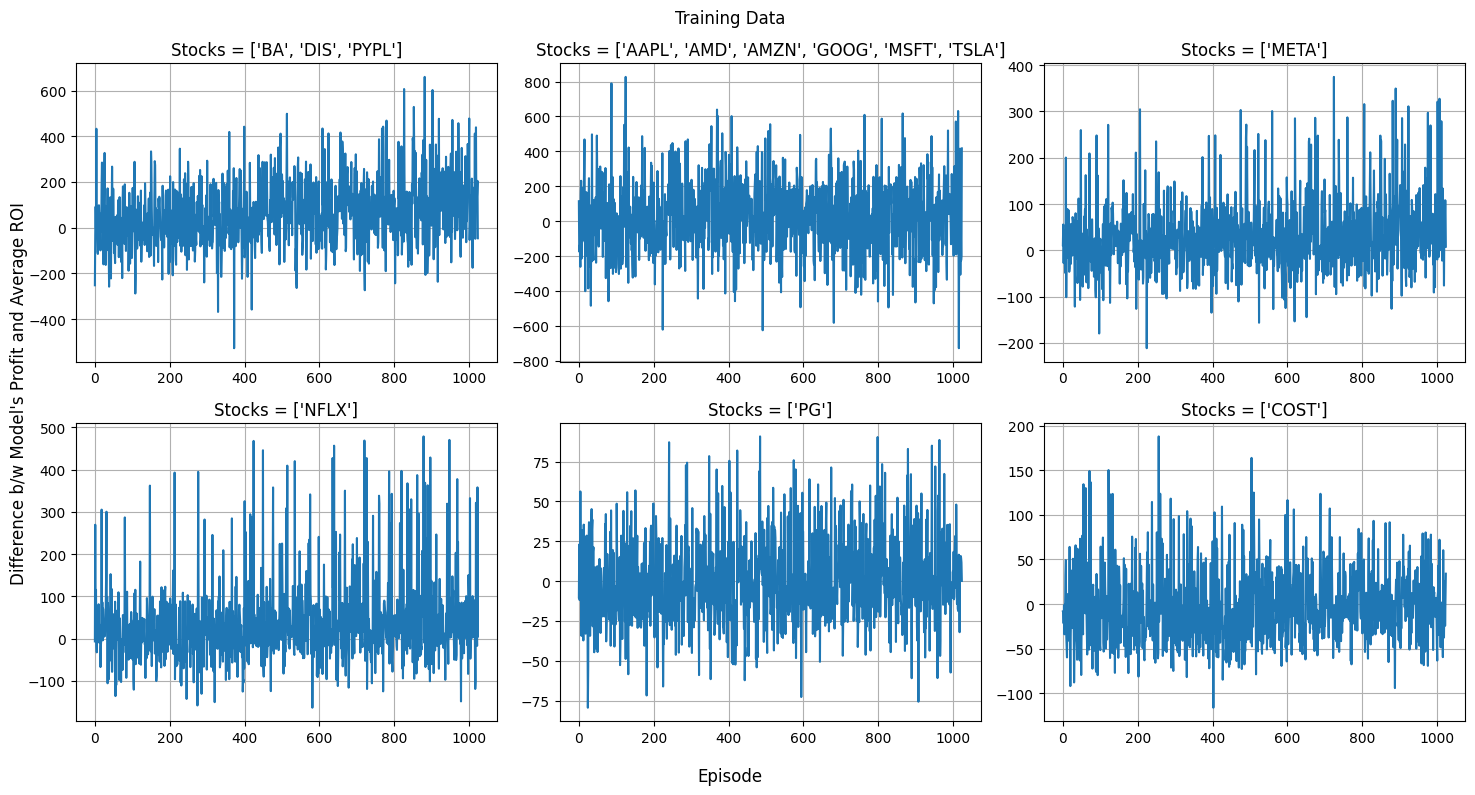

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(len(clusters)):
  row = i // 3
  col = i % 3
  with np.load(f"metrics_cluster{i}.npz") as metrics:
    model_comparison = metrics["train_profits"] - metrics["train_roi"]
    episodes = np.arange(len(model_comparison))
  axes[row, col].plot(episodes, model_comparison)
  axes[row, col].set_title(f"Stocks = {clusters[i]}")
  axes[row, col].grid(True)
fig.supylabel("Difference b/w Model's Profit and Average ROI")
fig.supxlabel("Episode")
fig.suptitle("Training Data")
plt.tight_layout()

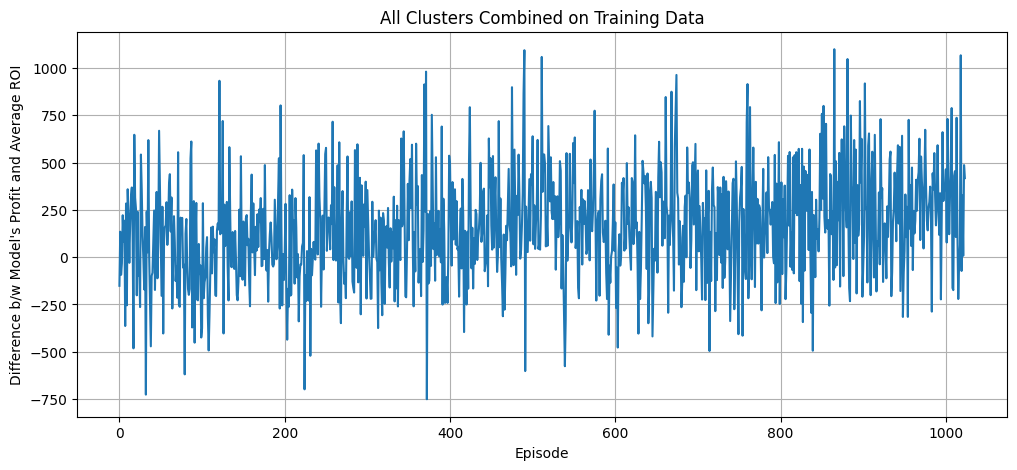

In [ ]:
model_comparison = 0
for i in range(len(clusters)):
  with np.load(f"metrics_cluster{i}.npz") as metrics:
    model_comparison += metrics["train_profits"] - metrics["train_roi"]
episodes = np.arange(len(model_comparison))
plt.figure(figsize=(12, 5))
plt.plot(episodes, model_comparison)
plt.xlabel("Episode")
plt.ylabel("Difference b/w Model's Profit and Average ROI")
plt.title("All Clusters Combined on Training Data")
plt.grid(True)

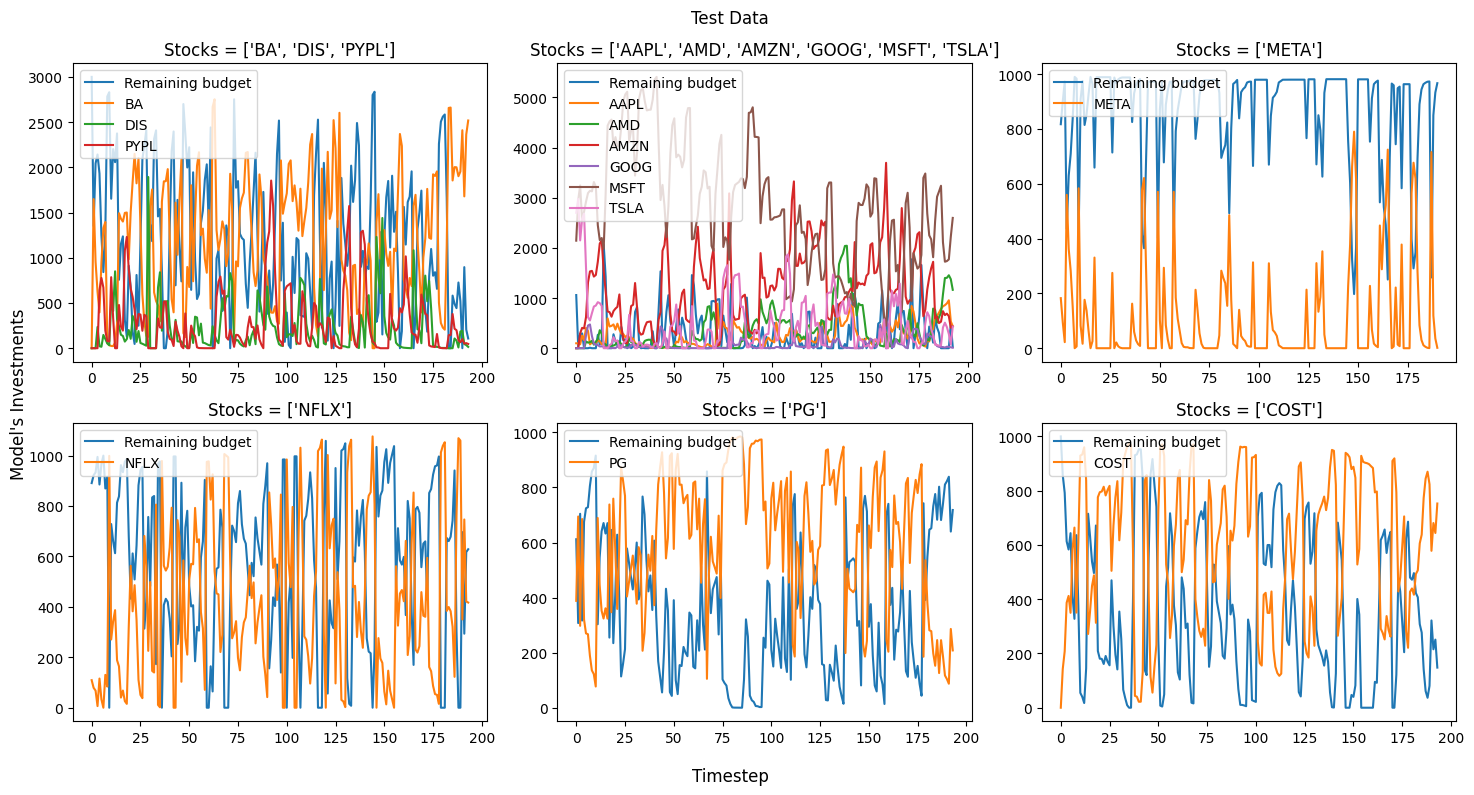

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(len(clusters)):
  row = i // 3
  col = i % 3
  with np.load(f"metrics_cluster{i}.npz") as metrics:
    test_funds = metrics["test_net_worth"]
    model_budget = test_funds[:, 0]
    model_stock_funds = test_funds[:, 1:]
    episodes = np.arange(len(model_budget))
    axes[row, col].plot(episodes, model_budget, label="Remaining budget")
    for stock in range(model_stock_funds.shape[1]):
      axes[row, col].plot(episodes, model_stock_funds[:, stock], label=clusters[i][stock])
    axes[row, col].set_title(f"Stocks = {clusters[i]}")
    axes[row, col].legend(loc='upper left')
fig.suptitle("Test Data")
fig.supylabel("Model's Investments")
fig.supxlabel("Timestep")
plt.tight_layout()

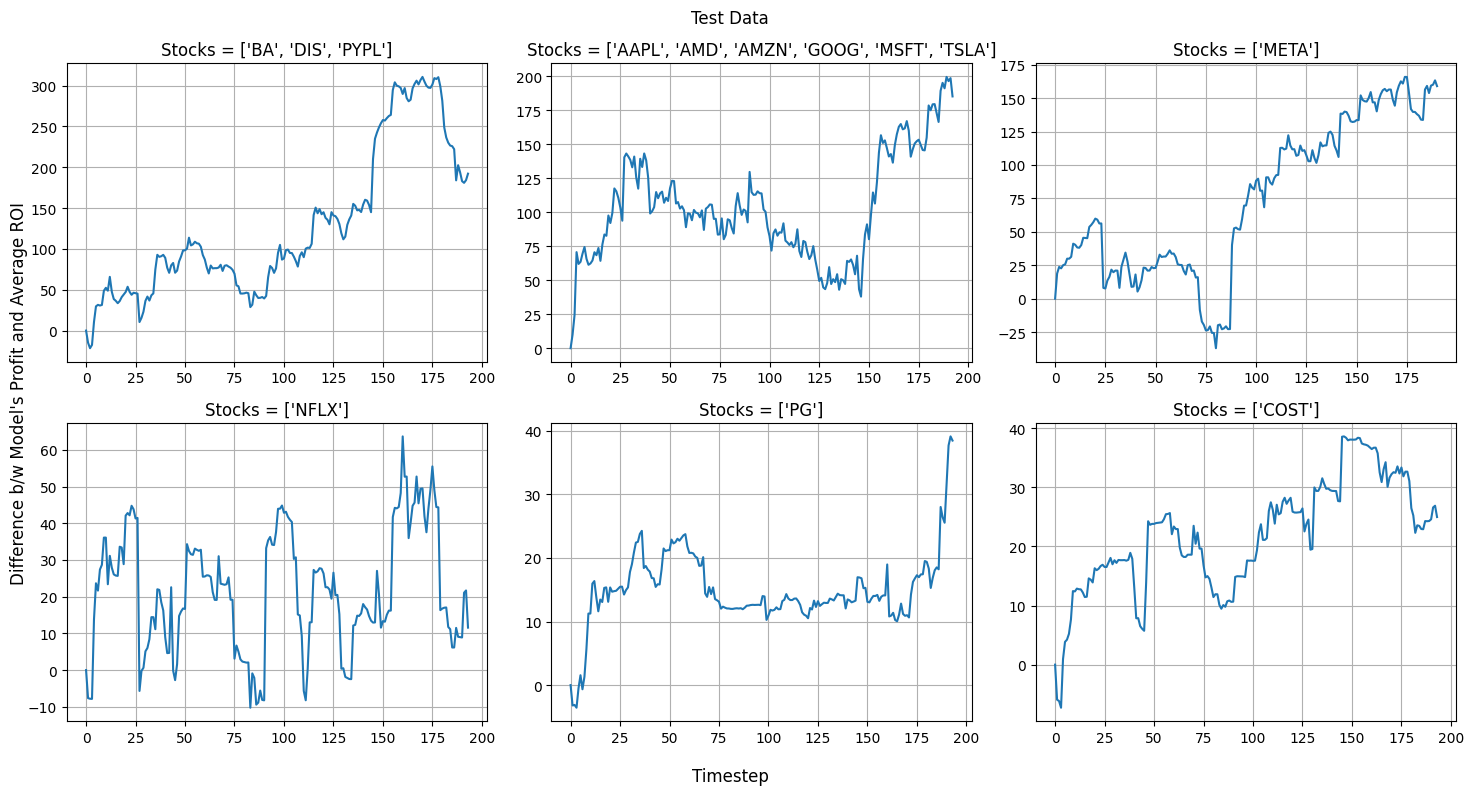

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(len(clusters)):
  row = i // 3
  col = i % 3
  with np.load(f"metrics_cluster{i}.npz") as metrics:
    test_funds = metrics["test_net_worth"]
    model_net_worth = test_funds.sum(axis=1)
    test_roi_stocks = metrics["test_roi"]
    test_roi = test_roi_stocks.sum(axis=1)
    model_comparison = model_net_worth - test_roi
    episodes = np.arange(len(model_comparison))
    axes[row, col].plot(episodes, model_comparison)
    axes[row, col].set_title(f"Stocks = {clusters[i]}")
    axes[row, col].grid(True)
fig.supylabel("Difference b/w Model's Profit and Average ROI")
fig.supxlabel("Timestep")
fig.suptitle("Test Data")
plt.tight_layout()

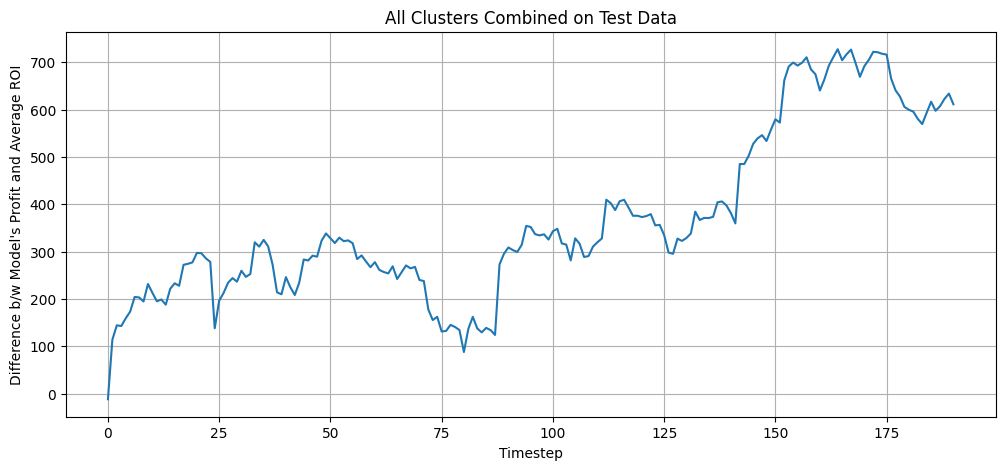

In [ ]:
model_comparison = 0
for i in range(len(clusters)):
  with np.load(f"metrics_cluster{i}.npz") as metrics:
    model_net_worth = metrics["test_net_worth"][-191:].sum(axis=1)
    test_roi = metrics["test_roi"][-191:].sum(axis=1)
    model_comparison += model_net_worth - test_roi
episodes = np.arange(len(model_comparison))
plt.figure(figsize=(12, 5))
plt.plot(episodes, model_comparison)
plt.xlabel("Timestep")
plt.ylabel("Difference b/w Model's Profit and Average ROI")
plt.title("All Clusters Combined on Test Data")
plt.grid(True)

In [ ]:
model_comparison = 0
with np.load(f"metrics_all_stocks.npz") as metrics:
  model_net_worth = metrics["test_net_worth"][-191:].sum(axis=1)
  test_roi = metrics["test_roi"][-191:].sum(axis=1)
  model_comparison += model_net_worth - test_roi
episodes = np.arange(len(model_comparison))
plt.figure(figsize=(12, 5))
plt.plot(episodes, model_comparison)
plt.xlabel("Timestep")
plt.ylabel("Difference b/w Model's Profit and Average ROI")
plt.title("All Stocks in Test Data")
plt.grid(True)